## Logistic Regression Implementation on (scaled) non-reduced dataset

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 42

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('CleanedData/dataset_preprocessed.csv')

Take sample for (initial) tests

In [4]:
df_scaled_sample = df_scaled.sample(n=500, random_state=seed)

Train-Test Split

In [5]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=seed
)

Save and print metrics

In [6]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted'),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

Model fit

In [7]:
model = LogisticRegression(random_state=seed)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [8]:
predictions = model.predict(X_test)

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

Metrics for LR1:
Accuracy: 0.6500
Weighted F1: 0.6265
Weighted Precision: 0.6613
Weighted Recall: 0.6500
Macro-Averaged Precision: 0.4524
Macro-Averaged Recall: 0.4334
F1: [0.         0.72       0.54794521]
Precision: [0.         0.61643836 0.74074074]
Confusion Matrix


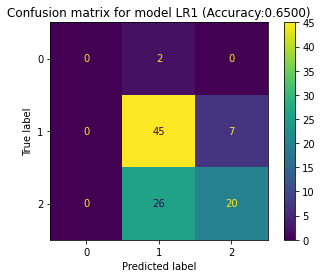

In [9]:
model_metrics = calculate_metrics('LR1', y_test, predictions)

In [10]:
# Apar warning-uri ptc nu converge daca max_iter e mic (<100)
# Maximu pe care l-am pus e 10k si acolo nu apare niciun warning dar am lasat ca lista
# Ptc modelele cele mai bune sunt la la max_iter <500
warnings.filterwarnings(action='ignore')

## Grid Search with Cross-Validation

In [11]:
# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [10, 100, 200, 500, 100, 1000, 5000],
    'solver': ['liblinear', 'saga']
}

# Perform grid search cross-validation
grid_search_cv = GridSearchCV(estimator=LogisticRegression(random_state=seed),
                               param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_cv.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_cv = grid_search_cv.best_params_
best_model_cv = grid_search_cv.best_estimator_

Results of the best model 

In [12]:
accuracy_cv = best_model_cv.score(X_test, y_test)

print("Best Hyperparameters:", best_params_cv)
print("Accuracy:", accuracy_cv)

Best Hyperparameters: {'C': 10, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.69


Results of best models Grid Search CV

In [13]:
df_cv = pd.DataFrame(grid_search_cv.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_cv = df_cv[['params', 'mean_test_score']]
df_results_cv_sorted = df_results_cv.sort_values(by='mean_test_score', ascending=False)

print(df_results_cv_sorted.head(5))

                                                params  mean_test_score
121  {'C': 10, 'max_iter': 200, 'penalty': 'l1', 's...           0.7575
112  {'C': 10, 'max_iter': 10, 'penalty': 'l1', 'so...           0.7575
149  {'C': 100, 'max_iter': 200, 'penalty': 'l1', '...           0.7550
144  {'C': 100, 'max_iter': 100, 'penalty': 'l1', '...           0.7525
152  {'C': 100, 'max_iter': 500, 'penalty': 'l1', '...           0.7525


Metrics for LR_CV1_best:
Accuracy: 0.6900
Weighted F1: 0.6757
Weighted Precision: 0.6900
Weighted Recall: 0.6900
Macro-Averaged Precision: 0.4714
Macro-Averaged Recall: 0.4632
F1: [0.         0.7394958  0.63291139]
Precision: [0.         0.65671642 0.75757576]
Confusion Matrix


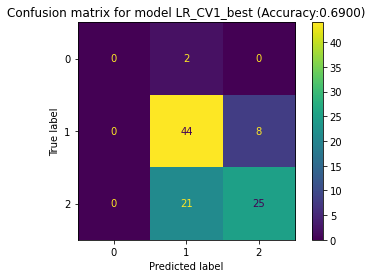

In [14]:
# Use best parameters to make predictions
predictions_cv = best_model_cv.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_CV1_best', y_test, predictions_cv)])

## Grid Search Stratified K Fold Validation

In [15]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search_skf = GridSearchCV(estimator=LogisticRegression(random_state=seed), 
                           param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search_skf.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_skf = grid_search_skf.best_params_
best_model_skf = grid_search_skf.best_estimator_

# Evaluate the best model on the test set
accuracy = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters with Stratified K-Fold:", best_params_skf)
print("Accuracy with Stratified K-Fold:", accuracy)


Best Hyperparameters with Stratified K-Fold: {'C': 10, 'max_iter': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy with Stratified K-Fold: 0.7


Results of the best model 

In [16]:
accuracy_skf = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters:", best_params_skf)
print("Accuracy:", accuracy_skf)

Best Hyperparameters: {'C': 10, 'max_iter': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.7


Results of best models Grid Search CV

In [17]:
df_skf = pd.DataFrame(grid_search_skf.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_skf = df_skf[['params', 'mean_test_score']]
df_results_skf_sorted = df_results_skf.sort_values(by='mean_test_score', ascending=False)

print(df_results_skf_sorted.head(5))

                                                params  mean_test_score
112  {'C': 10, 'max_iter': 10, 'penalty': 'l1', 'so...           0.7525
92   {'C': 1, 'max_iter': 200, 'penalty': 'l1', 'so...           0.7500
96   {'C': 1, 'max_iter': 500, 'penalty': 'l1', 'so...           0.7500
100  {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'so...           0.7500
88   {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'so...           0.7500


Metrics for LR_skf_best:
Accuracy: 0.7000
Weighted F1: 0.6864
Weighted Precision: 0.6937
Weighted Recall: 0.7000
Macro-Averaged Precision: 0.4733
Macro-Averaged Recall: 0.4705
F1: [0.         0.75213675 0.64197531]
Precision: [0.         0.67692308 0.74285714]
Confusion Matrix


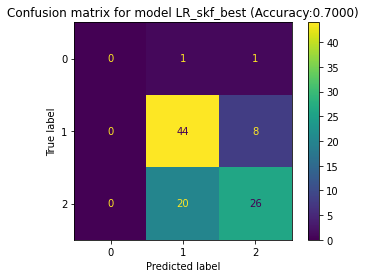

In [18]:
# Use best parameters to make predictions
predictions_skf = best_model_skf.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_skf_best', y_test, predictions_skf)])

Next maybe add elastic search as penalty? only works with saga solver

# Tune with Optuna

In [19]:
def objective(trial):
    # Define the hyperparameters to optimize
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform('C', 0.01, 10.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [20]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-04 20:59:11,334] A new study created in memory with name: no-name-60d51fd2-bc04-47c9-8d43-d1b720131efb
[I 2024-06-04 20:59:11,348] Trial 0 finished with value: 0.65 and parameters: {'penalty': 'l2', 'C': 1.5702970884055387, 'max_iter': 639, 'solver': 'liblinear'}. Best is trial 0 with value: 0.65.
[I 2024-06-04 20:59:11,385] Trial 1 finished with value: 0.66 and parameters: {'penalty': 'l2', 'C': 0.6358358856676253, 'max_iter': 737, 'solver': 'saga'}. Best is trial 1 with value: 0.66.
[I 2024-06-04 20:59:11,404] Trial 2 finished with value: 0.52 and parameters: {'penalty': 'l1', 'C': 0.035113563139704075, 'max_iter': 265, 'solver': 'saga'}. Best is trial 1 with value: 0.66.
[I 2024-06-04 20:59:11,696] Trial 3 finished with value: 0.69 and parameters: {'penalty': 'l1', 'C': 0.6847920095574779, 'max_iter': 225, 'solver': 'saga'}. Best is trial 3 with value: 0.69.
[I 2024-06-04 20:59:11,766] Trial 4 finished with value: 0.64 and parameters: {'penalty': 'l2', 'C': 0.039721107273

Best Hyperparameters: {'penalty': 'l1', 'C': 1.789011792871036, 'max_iter': 779, 'solver': 'saga'}
Best Accuracy: 0.72


Metrics for LR_OPT1_best:
Accuracy: 0.7200
Weighted F1: 0.7071
Weighted Precision: 0.7198
Weighted Recall: 0.7200
Macro-Averaged Precision: 0.4920
Macro-Averaged Recall: 0.4841
F1: [0.         0.76271186 0.675     ]
Precision: [0.         0.68181818 0.79411765]
Confusion Matrix


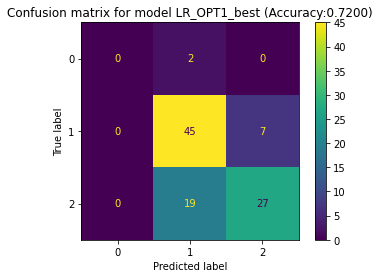

In [21]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt1 = best_model.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT1_best', y_test, predictions_opt1)])

In [22]:
study.best_params

{'penalty': 'l1', 'C': 1.789011792871036, 'max_iter': 779, 'solver': 'saga'}

In [23]:
optuna.visualization.plot_optimization_history(study)

In [24]:
optuna.visualization.plot_parallel_coordinate(study)

In [25]:
optuna.visualization.plot_slice(study, params=['penalty', 'C', 'max_iter', 'solver'])

In [26]:
optuna.visualization.plot_param_importances(study)

In [27]:
optuna.visualization.plot_edf(study)

Enlarge 'C' range and add elasticnet parameter (comes with l1_ratio)

In [28]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_loguniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [29]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-04 20:59:50,975] A new study created in memory with name: no-name-717b1bd2-8c87-4688-8338-c95ece23d64d
[I 2024-06-04 20:59:51,737] Trial 0 finished with value: 0.69 and parameters: {'l1_ratio': 0.3745401188473625, 'penalty': 'elasticnet', 'C': 63.512210106407046, 'max_iter': 759, 'solver': 'saga'}. Best is trial 0 with value: 0.69.
[I 2024-06-04 20:59:51,778] Trial 1 finished with value: 0.61 and parameters: {'l1_ratio': 0.5986584841970366, 'penalty': 'elasticnet', 'C': 0.04207988669606638, 'max_iter': 240, 'solver': 'saga'}. Best is trial 0 with value: 0.69.
[I 2024-06-04 20:59:52,147] Trial 2 finished with value: 0.68 and parameters: {'l1_ratio': 0.05808361216819946, 'penalty': 'elasticnet', 'C': 29.154431891537552, 'max_iter': 641, 'solver': 'saga'}. Best is trial 0 with value: 0.69.
[I 2024-06-04 20:59:52,165] Trial 3 finished with value: 0.52 and parameters: {'l1_ratio': 0.7080725777960455, 'penalty': 'elasticnet', 'C': 0.012087541473056965, 'max_iter': 973, 'solver': '

Best Hyperparameters: {'l1_ratio': 0.9540510272587224, 'penalty': 'elasticnet', 'C': 2.6588787786923436, 'max_iter': 306, 'solver': 'saga'}
Best Accuracy: 0.72


Metrics for LR_OPT2_best:
Accuracy: 0.7200
Weighted F1: 0.7071
Weighted Precision: 0.7198
Weighted Recall: 0.7200
Macro-Averaged Precision: 0.4920
Macro-Averaged Recall: 0.4841
F1: [0.         0.76271186 0.675     ]
Precision: [0.         0.68181818 0.79411765]
Confusion Matrix


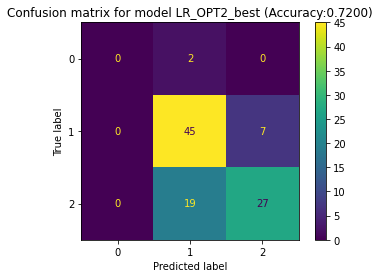

In [30]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt2 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT2_best', y_test, predictions_opt2)])

In [31]:
optuna.visualization.plot_param_importances(study)

Make 'C' interval uniform (as it remains the most important hyperparameter)

In [32]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_uniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [33]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-04 21:01:00,491] A new study created in memory with name: no-name-5f625c96-9bce-47bc-b430-2035629867be
[I 2024-06-04 21:01:01,087] Trial 0 finished with value: 0.7 and parameters: {'l1_ratio': 0.3745401188473625, 'penalty': 'elasticnet', 'C': 95.07192349792751, 'max_iter': 759, 'solver': 'saga'}. Best is trial 0 with value: 0.7.
[I 2024-06-04 21:01:01,333] Trial 1 finished with value: 0.68 and parameters: {'l1_ratio': 0.5986584841970366, 'penalty': 'elasticnet', 'C': 15.610303857839227, 'max_iter': 240, 'solver': 'saga'}. Best is trial 0 with value: 0.7.
[I 2024-06-04 21:01:01,946] Trial 2 finished with value: 0.69 and parameters: {'l1_ratio': 0.05808361216819946, 'penalty': 'elasticnet', 'C': 86.61895281603577, 'max_iter': 641, 'solver': 'saga'}. Best is trial 0 with value: 0.7.
[I 2024-06-04 21:01:02,103] Trial 3 finished with value: 0.68 and parameters: {'l1_ratio': 0.7080725777960455, 'penalty': 'elasticnet', 'C': 2.0682435846372864, 'max_iter': 973, 'solver': 'saga'}. B

Best Hyperparameters: {'l1_ratio': 0.3745401188473625, 'penalty': 'elasticnet', 'C': 95.07192349792751, 'max_iter': 759, 'solver': 'saga'}
Best Accuracy: 0.7


Metrics for LR_OPT3_best:
Accuracy: 0.7000
Weighted F1: 0.6864
Weighted Precision: 0.6937
Weighted Recall: 0.7000
Macro-Averaged Precision: 0.4733
Macro-Averaged Recall: 0.4705
F1: [0.         0.75213675 0.64197531]
Precision: [0.         0.67692308 0.74285714]
Confusion Matrix


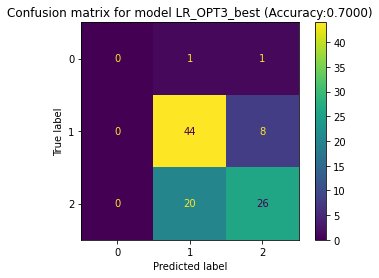

In [34]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt3 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT3_best', y_test, predictions_opt3)])

In [35]:
model_metrics

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
LR1,0.65,0.626455,0.661289,0.65,0.452393,0.433389,[0. 0.72 0.54794521],[0. 0.61643836 0.74074074]
LR_CV1_best,0.69,0.675677,0.689977,0.69,0.471431,0.463211,[0. 0.7394958 0.63291139],[0. 0.65671642 0.75757576]
LR_skf_best,0.70,0.686420,0.693714,0.70,0.473260,0.470457,[0. 0.75213675 0.64197531],[0. 0.67692308 0.74285714]
LR_OPT1_best,0.72,0.707110,0.719840,0.72,0.491979,0.484114,[0. 0.76271186 0.675 ],[0. 0.68181818 0.79411765]
LR_OPT2_best,0.72,0.707110,0.719840,0.72,0.491979,0.484114,[0. 0.76271186 0.675 ],[0. 0.68181818 0.79411765]
LR_OPT3_best,0.70,0.686420,0.693714,0.70,0.473260,0.470457,[0. 0.75213675 0.64197531],[0. 0.67692308 0.74285714]


end